In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import *
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from utils.text import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF

from run_id import run_id
stat = RunStats.objects.get(pk=run_id)
q = stat.query
print(q.title)



wos_all


In [2]:
docs = Doc.objects.filter(query=q)

js = docs.filter(journal__isnull=False).values('journal__id','journal__fulltext','journal__abbrev').annotate(
    n = Count('id')
)
top_js = js.order_by('-n')[:10]

In [3]:
jys = docs.filter(journal__in=top_js.values_list('journal_id',flat=True)).values('PY','journal__fulltext','journal__abbrev').annotate(
    n = Count('id')
)
df = pd.DataFrame.from_dict(list(jys))
df.head()

,PY,journal__abbrev,journal__fulltext,n
0,1981,GEOPHYS RES LETT,GEOPHYSICAL RESEARCH LETTERS,4
1,2007,CLIM DYNAM,CLIMATE DYNAMICS,102
2,1972,NATURE,NATURE,2
3,1980,GEOPHYS RES LETT,GEOPHYSICAL RESEARCH LETTERS,5
4,1995,J GEOPHYS RES-ATMOS,JOURNAL OF GEOPHYSICAL RESEARCH-ATMOSPHERES,61


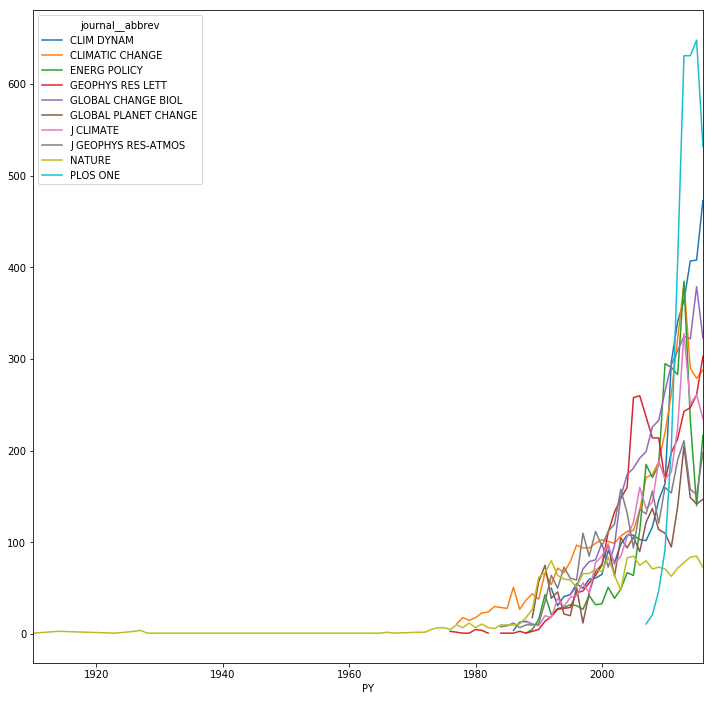

In [4]:
plt.rcParams["figure.figsize"] = [12,12]

pdf = df.pivot('PY','journal__abbrev','n')
pdf.head()

pdf.plot()
plt.savefig('../plots/journals/journal_papers.png',bbox_inches='tight')        
plt.show()

In [5]:
cjys = docs.filter(journal__in=top_js.values_list('journal_id',flat=True)).values('PY','journal__fulltext','journal__abbrev').annotate(
    n = Sum('wosarticle__tc')
)
df = pd.DataFrame.from_dict(list(cjys))
df.head()

,PY,journal__abbrev,journal__fulltext,n
0,1981,GEOPHYS RES LETT,GEOPHYSICAL RESEARCH LETTERS,224
1,2007,CLIM DYNAM,CLIMATE DYNAMICS,4499
2,1972,NATURE,NATURE,51
3,1980,GEOPHYS RES LETT,GEOPHYSICAL RESEARCH LETTERS,292
4,1995,J GEOPHYS RES-ATMOS,JOURNAL OF GEOPHYSICAL RESEARCH-ATMOSPHERES,6883


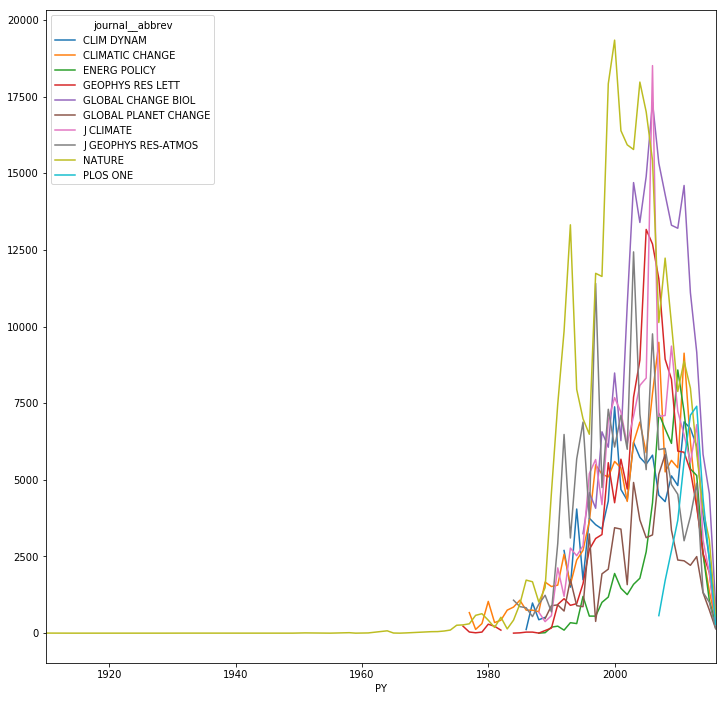

In [6]:
plt.rcParams["figure.figsize"] = [12,12]

pdf = df.pivot('PY','journal__abbrev','n')
pdf.head()

pdf.plot()

plt.show()

In [7]:
njournals = JournalAbbrev.objects.filter(doc__query=q).values('doc__PY').annotate(
    n = Count('id')
).order_by('doc__PY')
jdf = pd.DataFrame.from_dict(list(njournals))
#jdf = jdf.set_index('doc__PY')
jdf.head()

,doc__PY,n
0,1900,1
1,1903,1
2,1907,1
3,1910,2
4,1913,1


272023


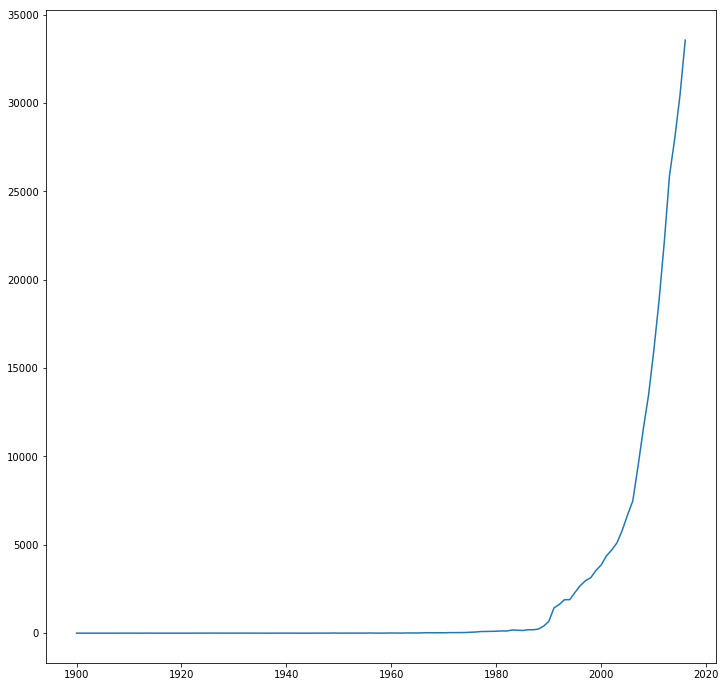

,doc__PY,n
0,1900,1
1,1903,1
2,1907,1
3,1910,2
4,1913,1


In [8]:
print(jdf['n'].sum())
plt.plot(jdf['doc__PY'],jdf['n'])
plt.savefig('../plots/journals/n_journals.png',bbox_inches='tight')        
plt.show()
jdf.head()

In [9]:
for j in top_js:
    print(j['journal__fulltext'])
    print(j['n'])
    dts = DocTopic.objects.filter(
        run_id=run_id,
        doc__journal__id=j['journal__id'],
        score__gt=stat.dthreshold
    )
    tops = dts.values('topic').annotate(
        t = Sum('score')
    )
    print(tops.values('topic__title','t').order_by('-t')[:10])

CLIMATIC CHANGE
4463
<QuerySet [{'topic__title': '{climat, chang, impact}', 't': 30.5509339492544}, {'topic__title': '{scenario, project, futur}', 't': 21.5567788797512}, {'topic__title': '{adapt, vulner, strategi}', 't': 16.0035543789395}, {'topic__title': '{temperatur, air, mean}', 't': 15.6337282688183}, {'topic__title': '{model, paramet, use}', 't': 14.8297268650314}, {'topic__title': '{region, area, local}', 't': 13.3865381978501}, {'topic__title': '{extrem, event, weather}', 't': 12.6913362510543}, {'topic__title': '{precipit, annual, increas}', 't': 12.2520520016206}, {'topic__title': '{data, method, estim}', 't': 12.0626429133623}, {'topic__title': '{research, manag, sustain}', 't': 12.0192157636911}]>
GLOBAL CHANGE BIOLOGY
4167
<QuerySet [{'topic__title': '{soil, moistur, respir}', 't': 25.8702251795938}, {'topic__title': '{elev, leaf, ambient}', 't': 25.8183088136539}, {'topic__title': '{speci, distribut, habitat}', 't': 22.0198893288917}, {'topic__title': '{ecosystem, servic

In [10]:
HJs = js.order_by('-n')[:30]

for j in HJs:
    print(j['journal__fulltext'])
    dts = DocTopic.objects.filter(
        run_id=run_id,
        doc__journal__id=j['journal__id'],
        score__gt=stat.dthreshold
    )
    H = 0
    ts = dts.values('topic').annotate(
        pzc = Sum('score')
    )
    for t in ts:
        H+=t['pzc']*np.log(t['pzc'])
    H = -1*H
    j['H'] = H
    print(round(H))

CLIMATIC CHANGE
-1142.0
GLOBAL CHANGE BIOLOGY
-1504.0
CLIMATE DYNAMICS
-1601.0
GEOPHYSICAL RESEARCH LETTERS
-1206.0
JOURNAL OF CLIMATE
-1305.0
PLOS ONE
-754.0
JOURNAL OF GEOPHYSICAL RESEARCH-ATMOSPHERES
-1082.0
ENERGY POLICY
-1021.0
GLOBAL AND PLANETARY CHANGE
-508.0
NATURE
-208.0
INTERNATIONAL JOURNAL OF GREENHOUSE GAS CONTROL
-431.0
PALAEOGEOGRAPHY PALAEOCLIMATOLOGY PALAEOECOLOGY
-408.0
ENVIRONMENTAL SCIENCE & TECHNOLOGY
-273.0
QUATERNARY SCIENCE REVIEWS
-469.0
SCIENCE
-98.0
JOURNAL OF CLEANER PRODUCTION
-360.0
PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCES OF THE UNITED STATES OF AMERICA
-230.0
ENERGY
-433.0
APPLIED ENERGY
-364.0
FOREST ECOLOGY AND MANAGEMENT
-427.0
RENEWABLE & SUSTAINABLE ENERGY REVIEWS
-419.0
INTERNATIONAL JOURNAL OF CLIMATOLOGY
-393.0
BIOGEOSCIENCES
-335.0
SCIENCE OF THE TOTAL ENVIRONMENT
-225.0
JOURNAL OF HYDROLOGY
-328.0
ENVIRONMENTAL RESEARCH LETTERS
-202.0
GLOBAL BIOGEOCHEMICAL CYCLES
-289.0
QUATERNARY INTERNATIONAL
-195.0
SOIL BIOLOGY & BIOCHEMISTRY
-309.0


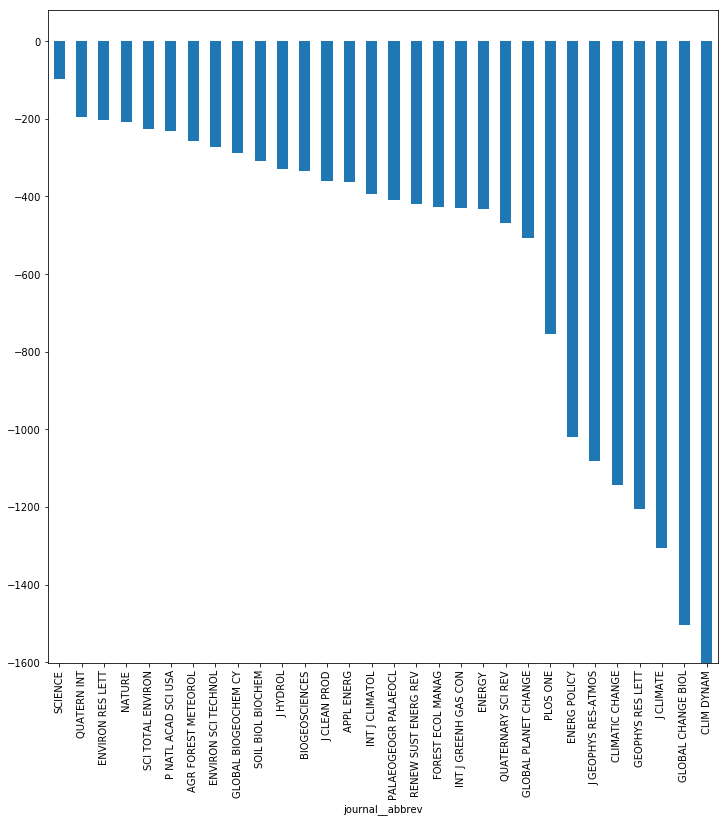

In [11]:
plt.rcParams["figure.figsize"] = [12,12]

df = pd.DataFrame.from_dict(list(HJs)).sort_values('H',ascending=False)

jorder = df['journal__abbrev']

df = df.set_index('journal__abbrev')

df.head()

df['H'].plot.bar()

plt.savefig('../plots/journals/journal_entropy_'+str(run_id)+'.png',bbox_inches='tight')        

plt.show()

# Entropy
$$ H(z\rvert c,y) = -\sum_{i=1}^{K} \hat{p}(z_i \rvert c,y)  log \hat{p}(z_i \rvert c, y) $$

In [12]:
dts = DocTopic.objects.filter(
    doc__journal__in=js.order_by('-n')[:30].values_list('journal__id'),
    run_id=run_id
)

dts = dts.values('doc__journal__abbrev','topic__title').annotate(
    s = Sum('score')
)
df = pd.DataFrame.from_dict(list(dts))

df.head()

,doc__journal__abbrev,s,topic__title
0,ENVIRON RES LETT,0.777595,"{lake, level, diatom}"
1,GLOBAL PLANET CHANGE,8.058815,"{precipit, annual, increas}"
2,ENVIRON RES LETT,1.683462,"{glacier, mass, retreat}"
3,PALAEOGEOGR PALAEOCL,1.627270,"{measur, sampl, ratio}"
4,INT J GREENH GAS CON,0.661442,"{flood, frequenc, damag}"


In [13]:
df['Journal'] = pd.Categorical(df['doc__journal__abbrev'],categories=jorder)
df['Topic'] = pd.Categorical(
    df['topic__title'],
    categories = list(Topic.objects.filter(
        run_id=run_id
    ).order_by('-score').values_list('title',flat=True)))
df = df.sort_values('Journal')
df.head()


,doc__journal__abbrev,s,topic__title,Journal,Topic
867,SCIENCE,1.271699,"{measur, sampl, ratio}",SCIENCE,"{measur, sampl, ratio}"
2597,SCIENCE,1.457934,"{cloud, feedback, radiat}",SCIENCE,"{cloud, feedback, radiat}"
1907,SCIENCE,3.621022,"{concentr, atmospher, increas}",SCIENCE,"{concentr, atmospher, increas}"
1861,SCIENCE,0.378995,"{ghg, mitig, greenhous}",SCIENCE,"{ghg, mitig, greenhous}"
1838,SCIENCE,0.950290,"{river, basin, runoff}",SCIENCE,"{river, basin, runoff}"


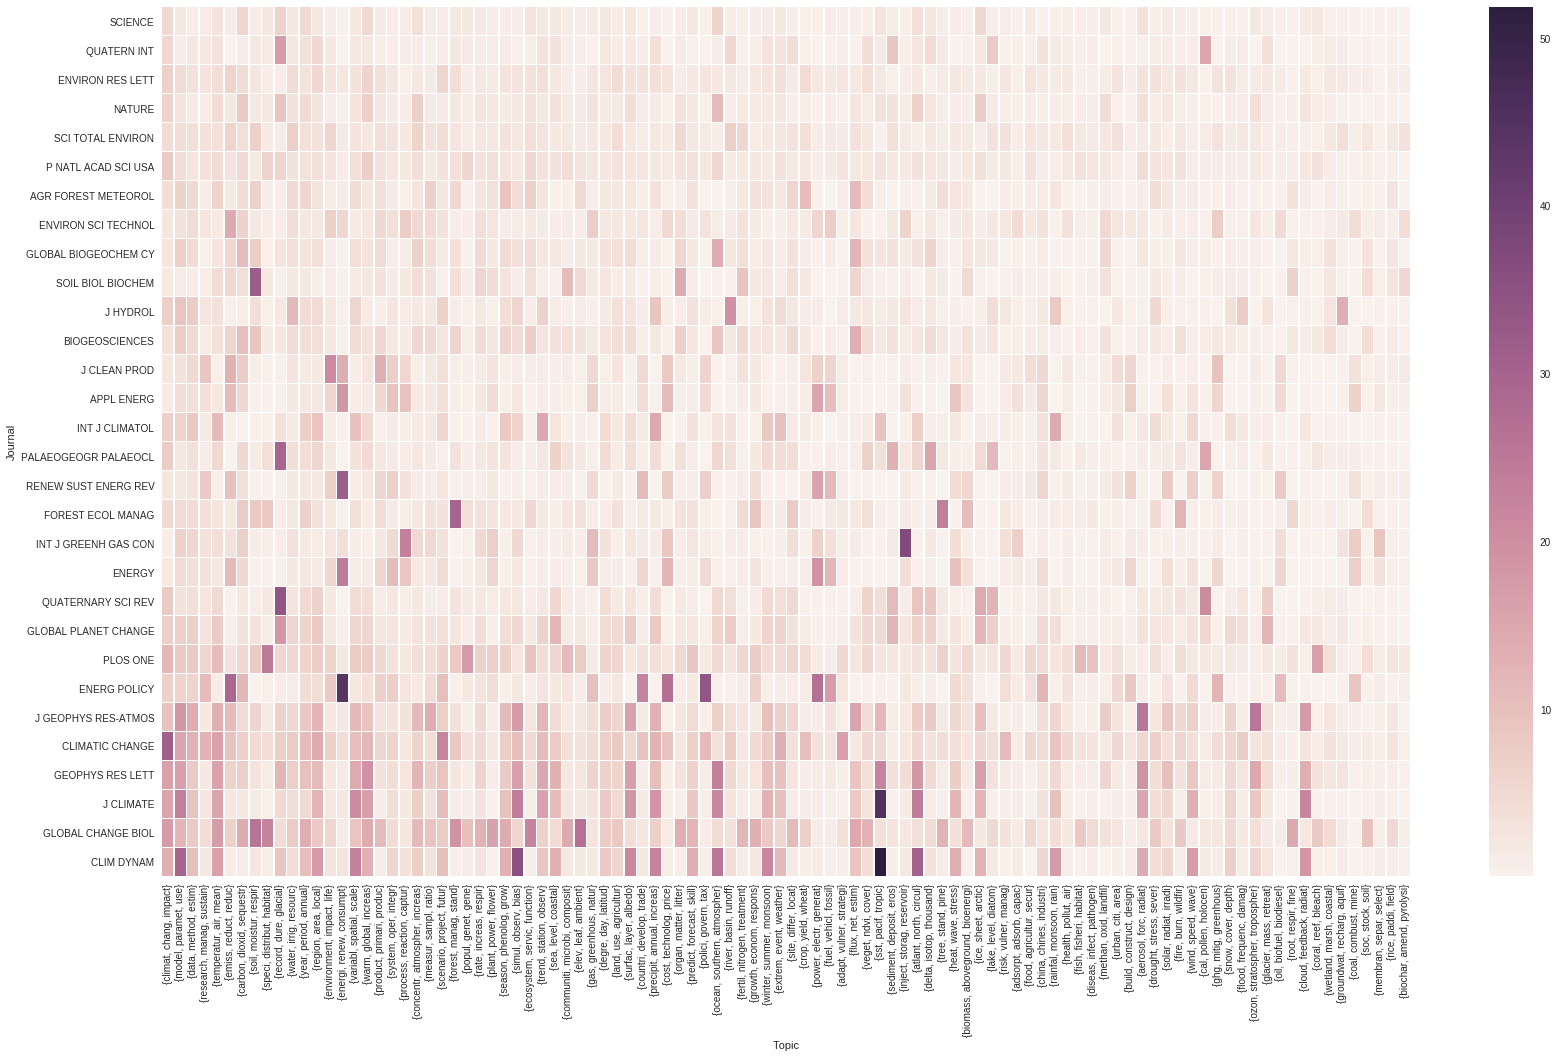

In [14]:
import seaborn as sns

pdf = df.pivot('Journal','Topic','s')

sns.set()

plt.rcParams["figure.figsize"] = [28,16]

sns.heatmap(pdf, linewidths=.5)

pdf.head()

plt.savefig('../plots/journals/journal_topics_'+str(run_id)+'.png',bbox_inches='tight')        

plt.show()

In [15]:
dts = DocTopic.objects.filter(
    doc__journal__fulltext="NATURE"
)

dts.count()

286798

In [16]:
ytopics = []
y = 1990

stat = RunStats.objects.get(pk=run_id)
dt_threshold=stat.dthreshold

[0,1985,1990.1,1995.1,2001.1,2007.1,2013.1,9999]
ars = [
    {"name":"AR0","years":range(0,1985),"n":0},
    {"name":"AR1","years":range(1985,1991),"n":1},
    {"name":"AR2","years":range(1991,1995),"n":2},
    {"name":"AR3","years":range(1995,2001),"n":3},
    {"name":"AR4","years":range(2001,2008),"n":4},
    {"name":"AR5","years":range(2008,2014),"n":5},
    {"name":"AR6","years":range(2014,9999),"n":6}
]
for ar in ars:   
    ytopics = dts.filter(
        doc__PY__in=ar["years"],
        run_id=run_id,
        score__gt=dt_threshold
    ).values('topic_id').annotate(
        ttotal=models.Sum('score')
    ).values('topic_id','topic__title','ttotal')
    ndf =  pd.DataFrame.from_dict(list(ytopics))
    ndf['AP'] = ar["name"]
    ndf['APn'] = ar["n"]
    if ar["name"]=="AR0":
        df = ndf
    else:
        df = df.append(ndf)

print(dt_threshold)       
df.head()


0.0024


,AP,APn,topic__title,topic_id,ttotal
0,AR2,2,"{diseas, infect, pathogen}",108916.0,0.017264
1,AR2,2,"{flood, frequenc, damag}",108910.0,0.134232
2,AR2,2,"{fire, burn, wildfir}",108896.0,0.100693
3,AR2,2,"{region, area, local}",108926.0,0.312642
4,AR2,2,"{system, oper, integr}",108915.0,0.143366


In [17]:

#df.groupby('topic__title')['ttotal'].mean()

0.0024


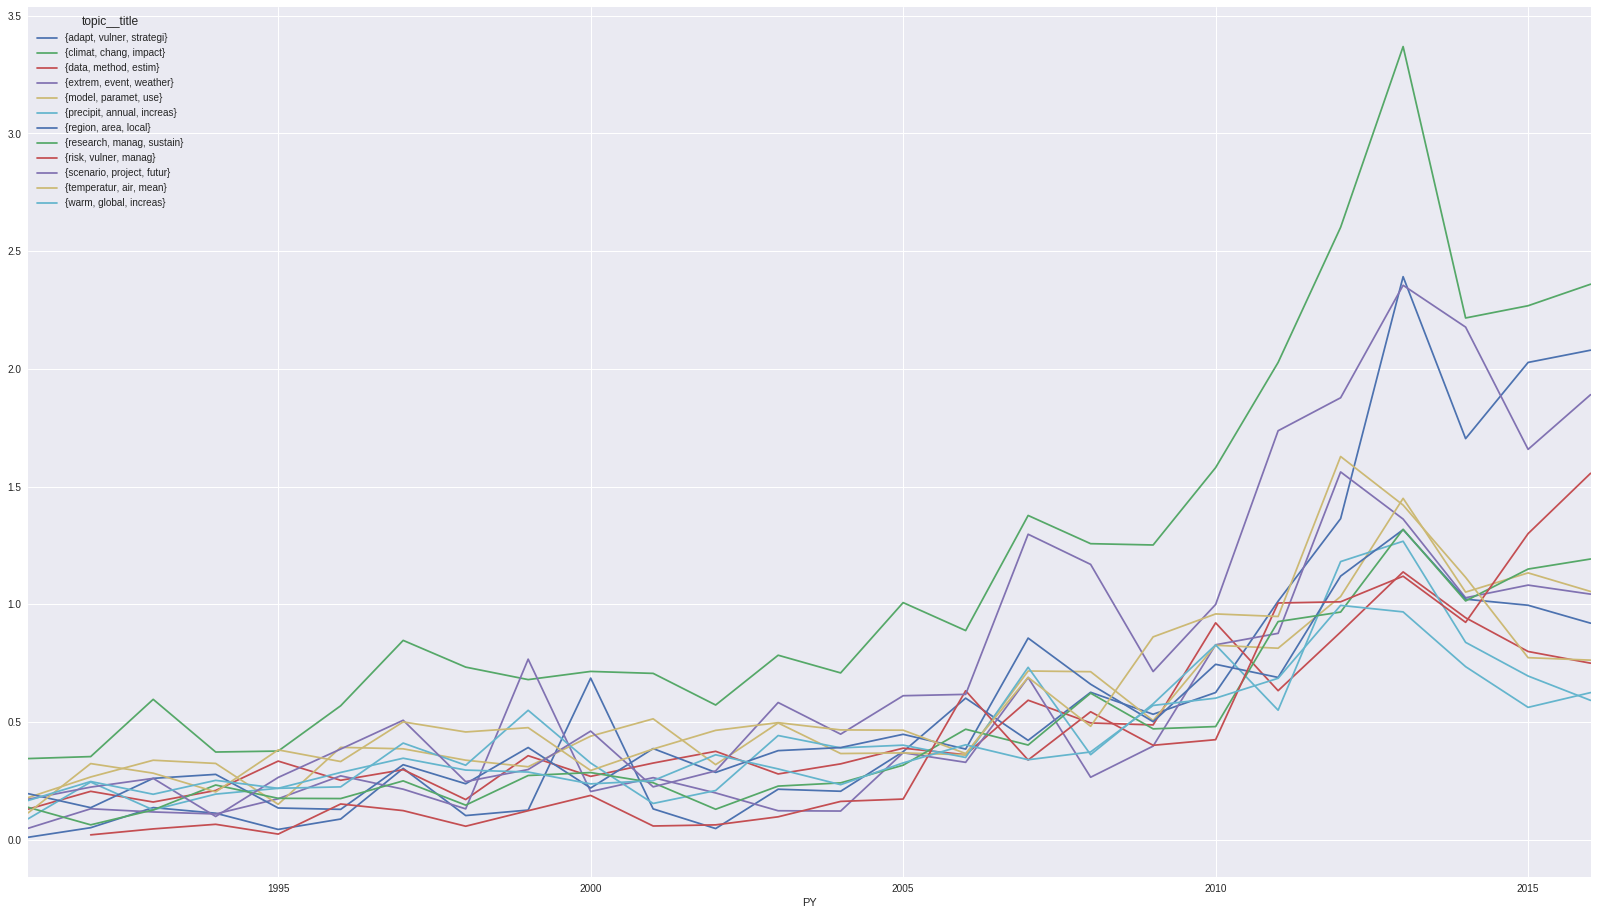

In [18]:
ytopics = []
y = 1990

stat = RunStats.objects.get(pk=run_id)
dt_threshold=stat.dthreshold

[0,1985,1990.1,1995.1,2001.1,2007.1,2013.1,9999]
ars = [
    {"name":"AR0","years":range(0,1985),"n":0},
    {"name":"AR1","years":range(1985,1991),"n":1},
    {"name":"AR2","years":range(1991,1995),"n":2},
    {"name":"AR3","years":range(1995,2001),"n":3},
    {"name":"AR4","years":range(2001,2008),"n":4},
    {"name":"AR5","years":range(2008,2014),"n":5},
    {"name":"AR6","years":range(2014,9999),"n":6}
]
for y in range(1980,2017):   
    ytopics = DocTopic.objects.filter(
        doc__PY=y,
        doc__journal__abbrev="CLIMATIC CHANGE",
        run_id=run_id,
        score__gt=dt_threshold
    ).values('topic_id').annotate(
        ttotal=models.Sum('score')
    ).values('topic_id','topic__title','ttotal')
    ndf =  pd.DataFrame.from_dict(list(ytopics))
    ndf['PY'] = y
    if y==1980:
        df = ndf
    else:
        df = df.append(ndf)

print(dt_threshold)       
df.head()

df['av'] = df.groupby('topic__title')['ttotal'].transform('mean')

pdf = df[df['av']>0.4].pivot('PY','topic__title','ttotal')


pdf.head()

pdf.plot()

plt.show()

In [19]:

df['x'] = df.apply(lambda x: x['APn']+(np.random.rand()-0.5)*0.5,axis=1)
df['change'] = df.ttotal - df.groupby(['topic__title']).ttotal.shift(1)
df['pchange'] = (df.ttotal - df.groupby(['topic__title']).ttotal.shift(1)) / df.groupby(['topic__title']).ttotal.shift(1) * 100
df.pchange=df['pchange']
#print(df[['APn','pchange']])
df['pchangen'] = df[['APn','pchange']].groupby('APn').transform(lambda x: x/x.max())

grouped = df.groupby('APn')

print(grouped.pchange.mean().reset_index())

df.tail()


KeyError: ('APn', 'occurred at index 0')

In [ ]:
pdf = df[df['ttotal']>0.2].pivot('APn','topic__title','ttotal')
pdf.head()

pdf.plot()

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [16,10]

topts = []

annotate = True

def f1(x):
    return '{0:.0f}%'.format(x)

ntopics = 5

for ar in ars:
    #break
    topar = df[df.AP==ar["name"]].sort_values(by='pchange', ascending=0).reset_index(drop=True)
    if ar["n"] > 2:
        # Write a table of top topics
        tab = topar[['topic__title','pchange']]
        tab['title'] = tab.apply(lambda x: x['topic__title'].replace('{','').replace('}',''),axis=1)
        tab = tab[['title','pchange']]  
        
        latex = tab.head(5).to_latex(float_format=f1,index=False)#,column_format='p{1.2cm}r')
        if ar["n"] > 5:
            with open("../tables/{}_top{}.tex".format(run_id,ar["name"]), "w") as f:
                f.write(latex)
 
            # Write a table of bottom topics
            latex = tab.tail(5).to_latex(float_format=f1,index=False)#,column_format='p{1.2cm}r')
            with open("../tables/{}_bottom{}.tex".format(run_id,ar["name"]), "w") as f:
                f.write(latex)

        
        #with open("../tables/top{}_tab.tex".format(ar["name"]), "w") as f:
        #    f.write(latex)
        plt.scatter(topar.x,topar.ttotal,s=topar.pchangen*5)
        i = 0
        for index, t in topar.head(ntopics).iterrows():
            
            if t.topic_id in topts:
                i = topts.index(t.topic_id)
                a = 0
            else:
                topts.append(t.topic_id)
                i = topts.index(t.topic_id)
                a = 1
            if annotate:
                text = plt.annotate(
                    t.topic__title,
                    #t.topic__title.replace(',','\n') + " (+{}%)".format(round(t.pchange*100)),
                    xy=(t.x,t.ttotal),
                    xytext=(0.7+i*0.25,20+i*11),
                    arrowprops=dict(facecolor='grey',width=0.01,headwidth=3,headlength=3,shrink=0.0001),
                    color = None
                    #size=0.5
                )
                text.set_alpha(a)
            else:
                plt.text(
                    t.x,
                    t.ttotal,
                    str(t.topic_id) #+ " (+{}%)".format(round(t.pchange*100))                
                )
        #for index, t in topar.tail().iterrows():
        #    plt.text(t.x,t.ttotal,t.topic__title)
        
tops = df[df.topic_id.isin(topts)]
tops = tops[tops.APn>0]

for name, group in tops.groupby(['topic_id']):
    plt.plot(group.x,group.ttotal,c="grey",lw=0.2)
    
plt.xticks([1,2,3,4,5,6],["AR1","AR2","AR3","AR4","AR5","AR6"])

wide = tops.pivot(index='topic__title',columns='AP',values='pchange').reset_index()
wide.columns.name = ''
wide= wide.reset_index(drop=True)

wider = tops[['topic_id','topic__title']].drop_duplicates().merge(wide,how="left").sort_values(by='topic_id')

i = 0
if not annotate:
    for index, t in wider.iterrows():
        i+=1
        plt.text(0.7,250-i*10,"{} : {}".format(t.topic_id,t.topic__title))
        
#plt.savefig('../plots/hot_topics'+str(run_id)+'.png',bbox_inches='tight')             
plt.show()